# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network



This is an implementation to the paper **"A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network"**. 




# Imports


In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,MaxPool1D,MaxPooling1D
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

# matplotlib Settings

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


# Variables Definitions

* **N (Normal):** The "N" represents a normal heartbeat or cardiac complex. It indicates that the electrical activity of the heart is within the normal range, and there are no abnormalities or irregularities in the heart rhythm.
* **L (Left bundle branch block):** An "L" complex indicates the presence of a left bundle branch block. This is an abnormality in the electrical conduction system of the heart, where the electrical signals do not travel normally through the left bundle branch. It can affect the timing and coordination of ventricular contractions.
* **R (Right bundle branch block):** An "R" complex indicates a right bundle branch block. Similar to left bundle branch block, this signifies an abnormality in the electrical conduction system involving the right bundle branch.
* **A (Atrial premature beat):** An "A" complex represents an atrial premature beat, which is an early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.
* **V (Ventricular premature beat):** A "V" complex represents a ventricular premature beat, which is an early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.


In [4]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 1000
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepere Input Files

In [5]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [6]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)
print(records[0])
print(annotations[0])

/kaggle/input/mitbit-arrhythmia-database/mitbih_database/100.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/100annotations.txt


# Data Extraction and Preprocessing

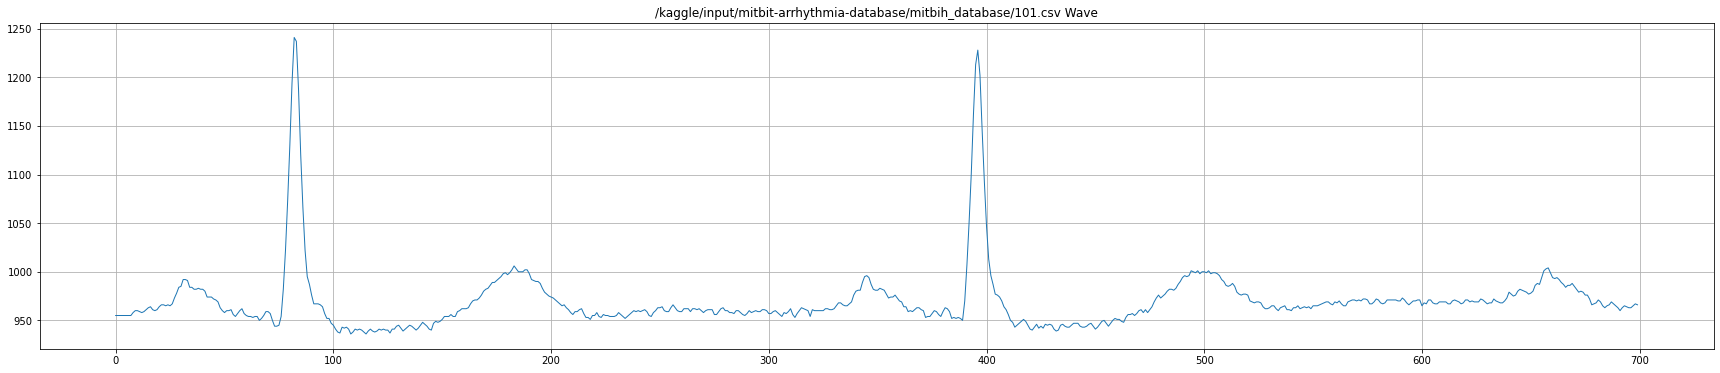

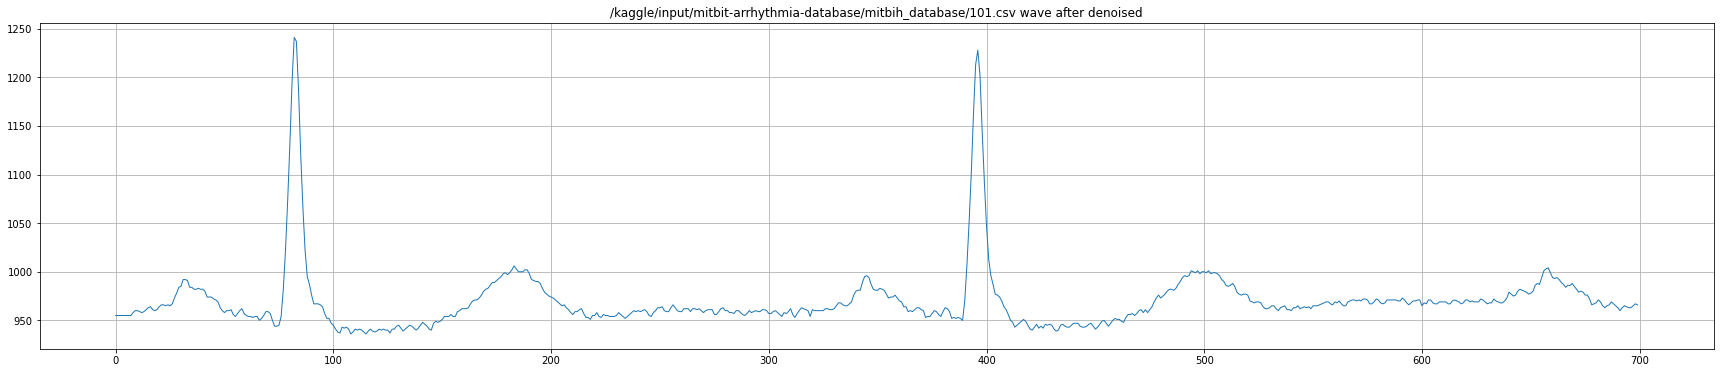

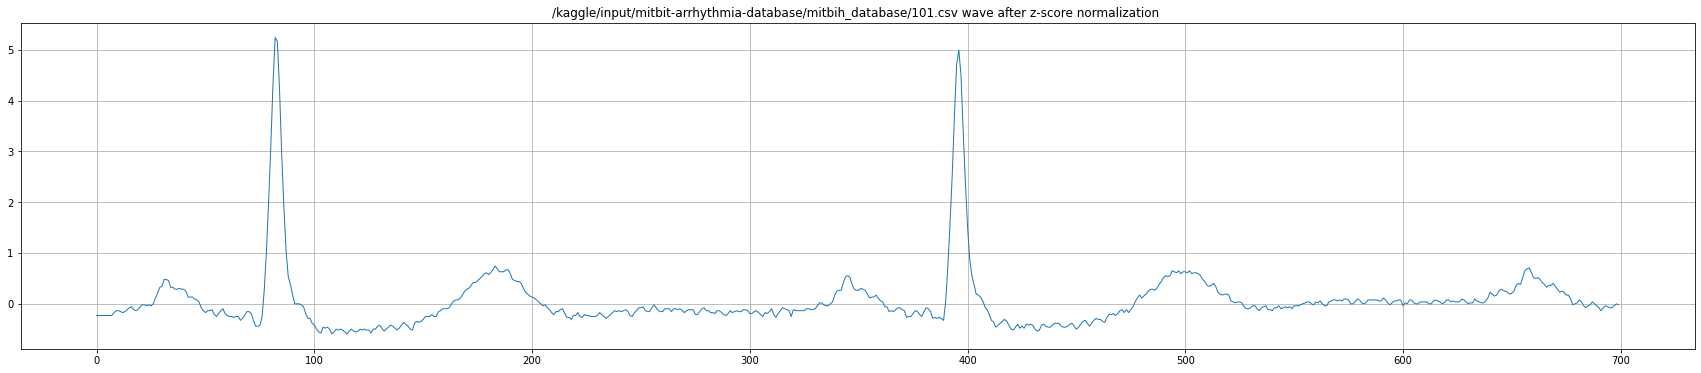

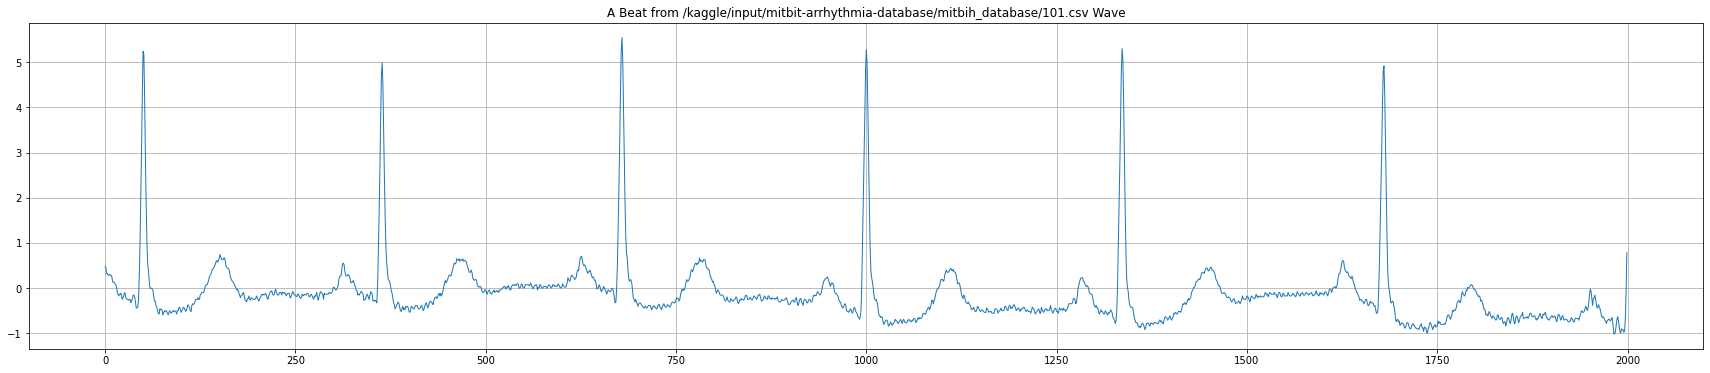

(99754, 2000) (99754,)


In [7]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [8]:
print(count_classes)

[75052, 8075, 7259, 2546, 7130]


In [9]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))


(99754, 2001)


In [10]:
print(X[1][360])

0.0067234989726539605


# Classes Distribution

0.0    74815
1.0     8053
2.0     7235
4.0     7114
3.0     2537
Name: 2000, dtype: int64


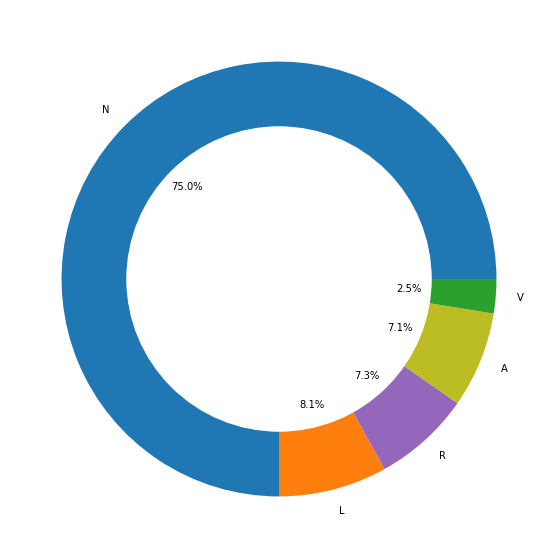

In [11]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [12]:
X_train_df.shape

(99754, 2001)

# Adding Gaussian Noise (Skipped as not denoising the data)

Noise is introduced into the data to simulate the influence of external unpredictable factors that might disrupt the process of recording data. The Additive White Gaussian Noise (AWGN) model is commonly employed for this purpose.

The term "additive" signifies that the noise generated is combined with the existing noise present in the system. When referring to "white noise," it indicates a random signal with consistent strength across various frequencies, resulting in a uniform power spectrum density. The descriptor "Gaussian" is used because the noise adheres to a normal distribution over the time domain.

In [13]:
'''row,column = X_train_df.shape
gaussian_noise = np.random.normal(0, 0.05, (row,column-1))
X_train_df_noise = X_train_df
X_train_df_noise = X_train_df.iloc[:,:-1] + gaussian_noise

plt.plot(X_train_df.iloc[1,:500], color='blue',label='Original Data')
plt.plot(X_train_df_noise.iloc[1,:500], color='orange', label='Noisy Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Original and Noisy Data')
plt.legend(['Original', 'Noisy'], loc='upper left')
plt.grid(True)
plt.show()
'''


"row,column = X_train_df.shape\ngaussian_noise = np.random.normal(0, 0.05, (row,column-1))\nX_train_df_noise = X_train_df\nX_train_df_noise = X_train_df.iloc[:,:-1] + gaussian_noise\n\nplt.plot(X_train_df.iloc[1,:500], color='blue',label='Original Data')\nplt.plot(X_train_df_noise.iloc[1,:500], color='orange', label='Noisy Data')\nplt.xlabel('Index')\nplt.ylabel('Value')\nplt.title('Comparison of Original and Noisy Data')\nplt.legend(['Original', 'Noisy'], loc='upper left')\nplt.grid(True)\nplt.show()\n"

In [14]:
#X_train_df.iloc[1,2000]

In [15]:
#X_train_df = X_train_df_noise
#del X_train_df_noise

In [16]:
X_train_df.shape

(99754, 2001)

In [17]:
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==1])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==1])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==2])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==3])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==4])

           0         1         2         3         4         5         6     \
12863  0.241029  0.241029  0.241029  0.200966  0.200966  0.190950  0.180934   
12864 -0.490120 -0.450057 -0.460073 -0.470089 -0.510152 -0.510152 -0.480105   
12865 -0.680420 -0.720483 -0.770561 -0.790593 -0.790593 -0.800609 -0.800609   
12866 -1.371506 -1.371506 -1.321427 -1.241301 -1.221270 -1.251317 -1.301396   
12867 -1.281364 -1.271349 -1.251317 -1.241301 -1.261333 -1.241301 -1.231286   
...         ...       ...       ...       ...       ...       ...       ...   
71164  0.034351  0.023715  0.044988  0.044988  0.013078  0.002441  0.055625   
71165 -0.135838 -0.135838 -0.135838 -0.125201 -0.103927 -0.157111 -0.157111   
71167 -0.103927 -0.135838 -0.146474 -0.167748 -0.157111 -0.157111 -0.157111   
71168 -0.550673 -0.561310 -0.561310 -0.593220 -0.603857 -0.582584 -0.571947   
71170  0.491734  0.470460  0.481097  0.491734  0.544918  0.534281  0.523645   

           7         8         9     ...      1991 

# Rebalancing Classes

In [18]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

4.0    5000
3.0    5000
2.0    5000
1.0    5000
0.0    5000
Name: 2000, dtype: int64


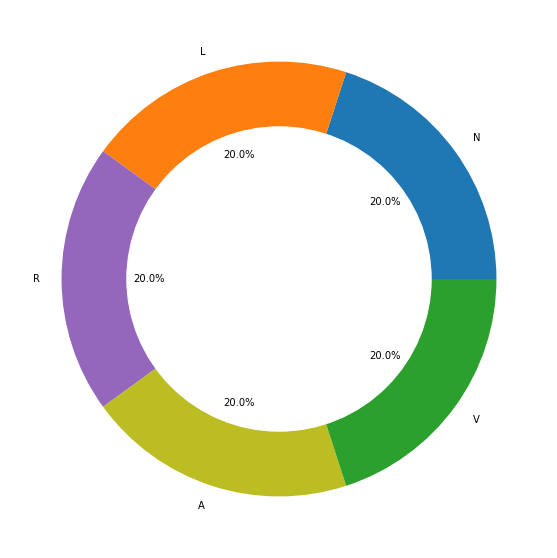

In [19]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [20]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 2001)
X_test  :  (5000, 2001)


In [21]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [22]:
train

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
14417,-0.480105,-0.500136,-0.490120,-0.520168,-0.550215,-0.550215,-0.550215,-0.540199,-0.520168,-0.560231,...,-0.109522,-0.089491,-0.069459,-0.069459,-0.079475,-0.109522,-0.119538,-0.069459,-0.049428,1.0
69511,-0.359211,-0.337937,-0.327300,-0.348574,-0.263479,-0.242206,-0.210295,-0.263479,-0.252842,-0.220932,...,-1.103787,-1.188882,-1.273976,-1.348434,-1.359070,-1.380344,-1.401618,-1.380344,-1.401618,1.0
87848,1.540031,1.482290,1.453420,1.366808,1.352373,1.395679,1.453420,1.482290,1.438984,1.438984,...,0.183119,0.298601,0.544000,0.890446,1.395679,1.886477,2.391710,2.709285,2.853637,4.0
20651,2.605766,2.533056,2.484583,2.399756,2.254337,2.060444,1.927144,1.793843,1.684779,1.575714,...,-0.508626,-0.484389,-0.484389,-0.435916,-0.460153,-0.448035,-0.484389,-0.472271,-0.472271,0.0
71127,-0.189022,-0.178385,-0.146474,-0.189022,-0.199658,-0.210295,-0.189022,-0.157111,-0.157111,-0.167748,...,-0.944235,-0.944235,-0.965509,-0.965509,-1.018693,-1.093150,-1.135698,-1.167608,-1.199518,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33062,-2.126771,-2.154783,-2.192133,-2.238819,-2.257494,-2.341530,-2.369542,-2.416228,-2.462915,-2.509602,...,0.263585,0.506355,0.786475,1.066595,1.384064,1.701533,2.037677,2.373820,2.756651,4.0
60062,-0.262265,-0.336862,-0.374160,-0.355511,-0.318212,-0.299563,-0.280914,-0.336862,-0.374160,-0.392809,...,0.595592,0.558293,0.465048,0.409101,0.390452,0.390452,0.427750,0.353154,0.259908,3.0
69124,-0.412395,-0.359211,-0.423031,-0.433668,-0.465579,-0.476215,-0.454942,-0.454942,-0.518763,-0.529399,...,-0.018833,0.013078,0.055625,0.076899,0.076899,0.066262,0.098172,0.130083,0.140719,1.0
13826,-0.660388,-0.660388,-0.680420,-0.730498,-0.730498,-0.720483,-0.720483,-0.730498,-0.750530,-0.800609,...,-0.219695,-0.209680,-0.199664,-0.219695,-0.249743,-0.249743,-0.249743,-0.219695,-0.219695,1.0


In [23]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))
print(np.shape(train_y),np.shape(test_y))

(20000, 2000, 1) (5000, 2000, 1)
(20000, 5) (5000, 5)


## Building the Model Architecture


In [24]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=train_x[0].shape))


# Adding an Max Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(MaxPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# Adding an Max Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(MaxPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# Adding an Max Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(MaxPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# Adding an Max Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(MaxPool1D(pool_size=3, strides=2))



# Flattening the layer 
# There would be 128*(21*1) = 2688 neurons
model.add(Flatten())


# Dropout the layer S9
model.add(Dropout(0.5))



# Adding a Dense layer with regularization l2(0.0001)# S10
# No. of inputs = 2688
# No. of outputs = 35
# No. of parameters = 2688 x 35 + 35 = 94115
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Dense layer with regularization l2(0.0001)# S11
# No. of inputs = 35
# No. of outputs = 5
# No. of parameters = 35*5 + 5 = 180
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2000, 16)          224       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 999, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 999, 32)           7712      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 499, 64)           34880     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 249, 128)          1

## Compiling the model

In [25]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

## Fitting the model

In [26]:
history = model.fit(train_x, train_y, batch_size=75, epochs=50, verbose=1, validation_data=(test_x, test_y))

Epoch 1/50
267/267 [==============================] - 10s 17ms/step - loss: 0.7725 - accuracy: 0.6982 - val_loss: 0.1089 - val_accuracy: 0.9726
Epoch 2/50
267/267 [==============================] - 4s 14ms/step - loss: 0.1035 - accuracy: 0.9719 - val_loss: 0.0749 - val_accuracy: 0.9824
Epoch 3/50
267/267 [==============================] - 4s 14ms/step - loss: 0.0615 - accuracy: 0.9843 - val_loss: 0.0685 - val_accuracy: 0.9888
Epoch 4/50
267/267 [==============================] - 4s 14ms/step - loss: 0.0473 - accuracy: 0.9889 - val_loss: 0.0690 - val_accuracy: 0.9864
Epoch 5/50
267/267 [==============================] - 4s 14ms/step - loss: 0.0447 - accuracy: 0.9906 - val_loss: 0.0622 - val_accuracy: 0.9896
Epoch 6/50
267/267 [==============================] - 4s 14ms/step - loss: 0.0399 - accuracy: 0.9926 - val_loss: 0.0627 - val_accuracy: 0.9902
Epoch 7/50
267/267 [==============================] - 4s 14ms/step - loss: 0.0382 - accuracy: 0.9940 - val_loss: 0.0606 - val_accuracy: 0.991

**Plotting the loss convergence**

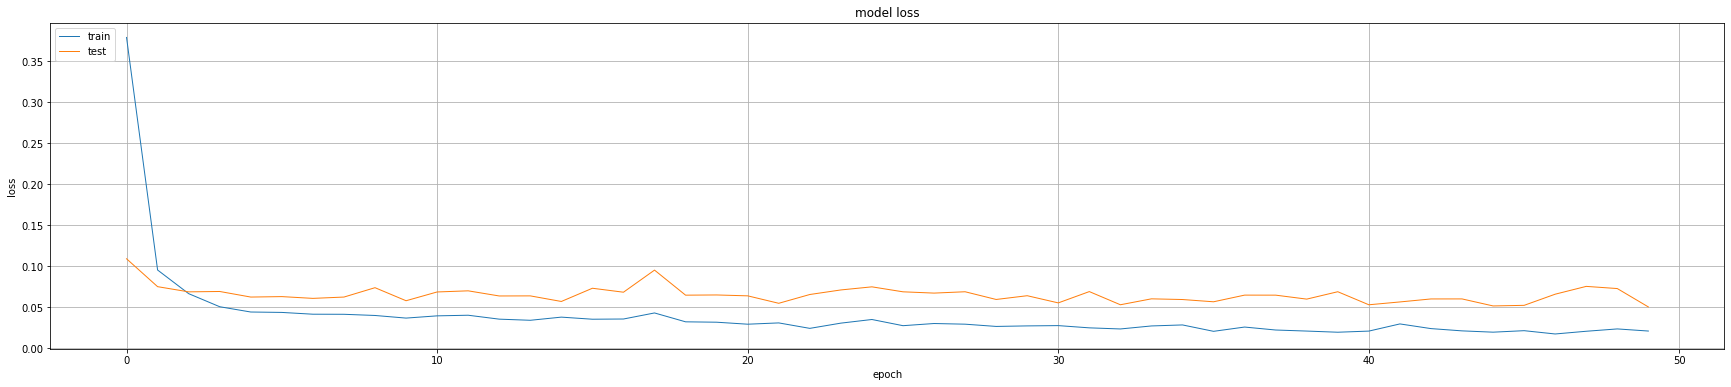

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

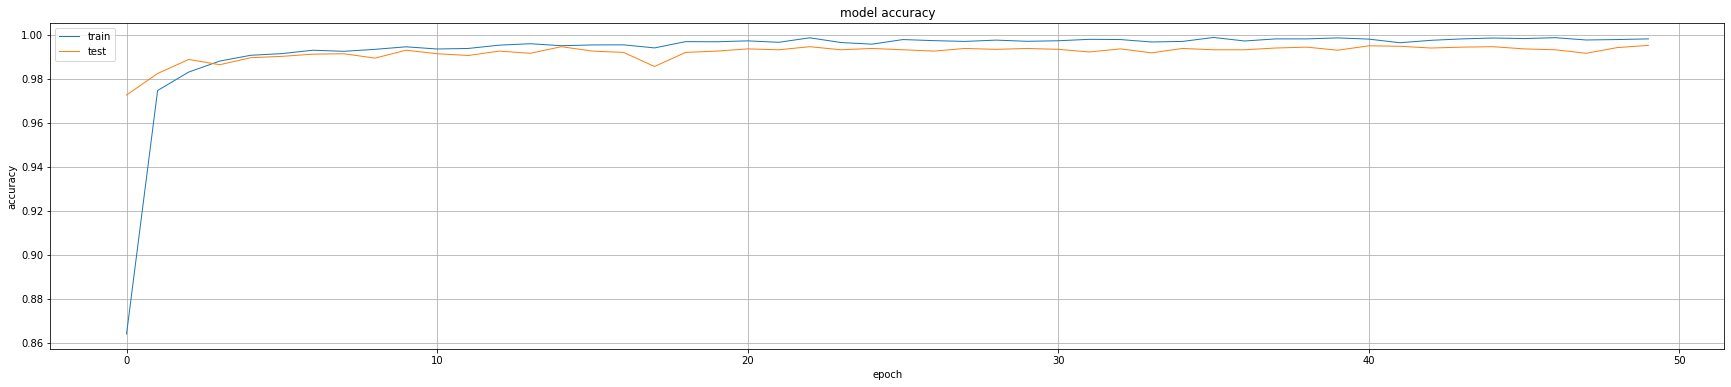

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
model.save(f'arryhtmia-classification-{window_size}.h5')

## Finding the loss and accuracy of the model

In [30]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 1s 4ms/step - loss: 0.0501 - accuracy: 0.9952
Test Loss: 0.05011938139796257
Test accuracy: 0.995199978351593


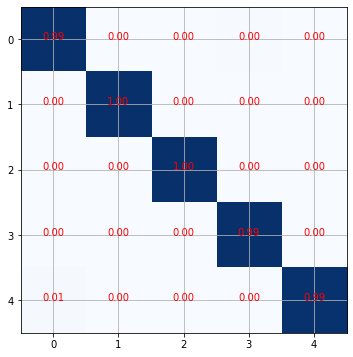

In [31]:
from sklearn.metrics import f1_score, confusion_matrix
pred_y = model.predict(test_x)
cm = confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="red")


plt.imshow(cm, cmap=plt.cm.Blues)

In [32]:
# Test data class labels spread

print("The distribution of test set labels")
print(test[X_train_df.shape[1]-1].value_counts())

print('F1_score = ', f1_score(test_y.argmax(axis=1), pred_y.argmax(axis=1), average = 'macro'))


The distribution of test set labels
2.0    1040
0.0    1022
1.0     991
4.0     983
3.0     964
Name: 2000, dtype: int64
F1_score =  0.9951731098329992


# Notations
* **N (Normal):** The "N" represents a normal heartbeat or cardiac complex. It indicates that the electrical activity of the heart is within the normal range, and there are no abnormalities or irregularities in the heart rhythm.
* **L (Left bundle branch block):** An "L" complex indicates the presence of a left bundle branch block. This is an abnormality in the electrical conduction system of the heart, where the electrical signals do not travel normally through the left bundle branch. It can affect the timing and coordination of ventricular contractions.
* **R (Right bundle branch block):** An "R" complex indicates a right bundle branch block. Similar to left bundle branch block, this signifies an abnormality in the electrical conduction system involving the right bundle branch.
* **A (Atrial premature beat):** An "A" complex represents an atrial premature beat, which is an early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.
* **V (Ventricular premature beat):** A "V" complex represents a ventricular premature beat, which is an early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.

Actual label:  L
Model prediction :  L  with probability  1.0


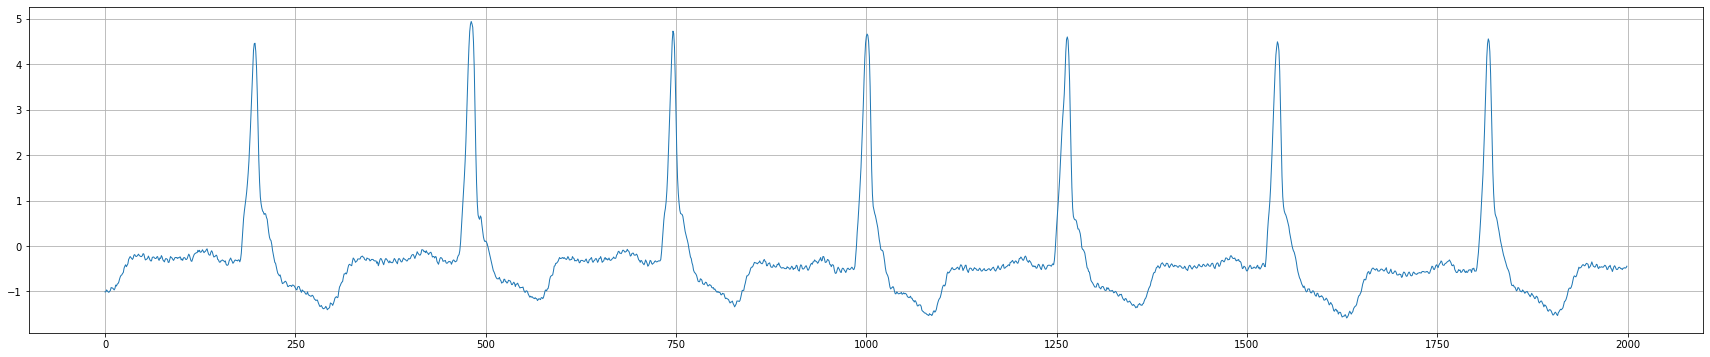

In [33]:
import random
i = random.randint(0, len(test_x)-1)

output = model(np.expand_dims(test_x[i], 0))

pred = output.numpy()[0]

plt.plot(test_x[i])

print("Actual label: ", classes[np.argmax(test_y[i])])
print("Model prediction : ", classes[np.argmax(pred)], " with probability ", pred[np.argmax(pred)])